## Part 2: Indexing and Evaluation

In [1]:
import array
import collections
import csv
import datetime
import json
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import spacy
from collections import Counter, defaultdict
import time
from array import array
import math
from numpy import linalg as la

In [2]:
# Function to ...
def build_terms(line):

    filtered_line = line.lower() ## Transform in lowercase
    filtered_line = filtered_line.split() ## Tokenize the text to get a list of terms
    filtered_line = [re.sub(r'[^\w\s]', '', word) for word in filtered_line] # Removing non-words and non-whitespaces
    
    # Removing stop words
    stop_words = set(stopwords.words("english"))
    filtered_line = [word for word in filtered_line if word not in stop_words]  ## Eliminate the stopwords 

    # Stemming
    stemmer = PorterStemmer()
    filtered_line = [stemmer.stem(word) for word in filtered_line] ## Perform stemming

    return filtered_line

In [3]:
# Function to ...
def remove_emoticons(text):
    # Define a pattern to find all the emoticons
    emoticon_pattern = re.compile("[" u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF" 
                                  u"\U0001F680-\U0001F6FF" u"\U0001F1E0-\U0001F1FF" 
                                  u"\U00002500-\U00002BEF" u"\U00002702-\U000027B0" 
                                  u"\U000024C2-\U0001F251" u"\U0001f926-\U0001f937" 
                                  u"\U00010000-\U0010ffff" u"\u2640-\u2642" 
                                  u"\u2600-\u2B55" u"\u200d" 
                                  u"\u23cf" u"\u23e9" 
                                  u"\u231a" u"\ufe0f" 
                                  u"\u3030" "]+", re.UNICODE)

    # Replace emoticons with an empty string
    text_without_emoticons = emoticon_pattern.sub('', text)

    return str(text_without_emoticons)

In [4]:
# Function to ...
def remove_links(text):
    # Define a pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Replace URLs with an empty string
    text_without_links = url_pattern.sub('', text)

    return str(text_without_links)  

# PRE-PROCESS OF THE DOCUMENT

In [10]:
# Load the JSON data

with open('IRWA_data_2023/Rus_Ukr_war_data.json', 'r') as fp:
    lines = fp.readlines()
lines = [l.strip().replace(' +', ' ') for l in lines]

tweet_information = {}
for line in lines:

        tweet_data = json.loads(line)

        # Clean the text
        tweet_text = tweet_data['full_text']
        tweet_text = remove_emoticons(tweet_text)
        tweet_text = remove_links(tweet_text)

        # Extract relevant information
        tweet_id = tweet_data['id_str']
        tweet_date = tweet_data['created_at']
        hashtags = [hashtag['text'] for hashtag in tweet_data['entities']['hashtags']]
        likes = tweet_data['favorite_count']
        retweets = tweet_data['retweet_count'] 
        twitter_username = tweet_data['user']['screen_name']
        tweet_url = f"https://twitter.com/{twitter_username}/status/{tweet_id}"

        processed_tweet = build_terms(tweet_text)

        # Store all the tweet information
        tweet_information[tweet_id] = {
            'Tweet ID': tweet_id,
            'Tweet Text': tweet_text,
            'Processed Tweet': processed_tweet,
            'Tweet Date': tweet_date,
            'Hashtags': hashtags,
            'Likes': likes,
            'Retweets': retweets,
            'Tweet_url': tweet_url
        }

# Map tweet IDs with document IDs for evaluation stage
tweet_document_ids_map = {}
tweet_document_ids_map1 = {}

with open('IRWA_data_2023/Rus_Ukr_war_data_ids.csv', 'r') as map_file:
    doc = csv.reader(map_file, delimiter='\t')
    for row in doc:
        doc_id, tweet_id = row
        tweet_document_ids_map[doc_id] = tweet_id
        tweet_document_ids_map1[tweet_id] = doc_id

# INDEXING

In [11]:
# Function to ...
def create_index_tfidf(lines, num_documents):

    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    url_index = defaultdict(str)
    idf = defaultdict(float)

    for line in lines:
        tweet_data = json.loads(line)
        tweet_id = tweet_data['id_str']
        
        doc_id = tweet_document_ids_map1[tweet_id]
        terms = tweet_information[tweet_id]['Processed Tweet']
        url_index[doc_id] = tweet_information[tweet_id]['Tweet_url']

        current_page_index = {}

        for position, term in enumerate(terms):
            try:
                current_page_index[term][1].append(position)
            except:
                current_page_index[term] = [doc_id, array('I',[position])] #'I' indicates unsigned int (int in Python)

        norm = 0
        for term, posting in current_page_index.items():
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        for term, posting in current_page_index.items():
            tf[term].append(np.round(len(posting[1])/norm,4))
            df[term] += 1

        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return index, tf, df, idf, url_index

In [12]:
# Function to ...
def rank_documents(terms, docs, index, idf, tf, url_index):
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.
    
    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        query_vector[termIndex] = query_terms_count[term]/query_norm * idf[term]

        for doc_index, (doc, postings) in enumerate(index[term]):
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]

    # Cosine similarity
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    return result_docs, doc_scores

In [13]:
# Function to ...
def search_tf_idf(query, index):
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            term_docs=[posting[0] for posting in index[term]]
            docs |= set(term_docs)
        except:
            pass
    docs = list(docs)
    ranked_docs, cosine_similarity = rank_documents(query, docs, index, idf, tf, url_index)
    return ranked_docs, cosine_similarity

In [14]:
start_time = time.time()
num_documents = len(lines)
index, tf, df, idf, url_index = create_index_tfidf(lines, num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 138.97 seconds


In [15]:
q = True
while q == True:
    print("\nInsert your query or END to stop(i.e.: presidents visiting Kyiv):\n")
    query = input()
    print(query)
    if query == 'END':
        break
    ranked_docs, cosine_similarity = search_tf_idf(query, index)
    top = 10
    # print(cosine_similarity)
    print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
    for d_id in ranked_docs[:top]:
        print("doc_id = {} - tweet_url: {}".format(d_id, url_index[d_id]))


Insert your query or END to stop(i.e.: presidents visiting Kyiv):

END


In [ ]:
docs = ['doc_2052','doc_164','doc_411','doc_1805','doc_3442','doc_2657','doc_1534','doc_383','doc_1618','doc_63','doc_3803','doc_1069','doc_2852','doc_3445','doc_421','doc_3478','doc_3705','doc_3422','doc_650','doc_2442','doc_1452','doc_2908','doc_618','doc_2677','doc_489','doc_110','doc_3439','doc_3137','doc_3913','doc_2696','doc_2234','doc_2656','doc_3709','doc_592','doc_3556','doc_2586','doc_2701','doc_3478','doc_2956','doc_3552']
for doc in docs:
    for x in cosine_similarity:
        if doc == x[1]:
            print(x)
            break
        else:
            if x == cosine_similarity[-1]:
                print([0.0, doc])
                break

[3.666122052428008, 'doc_2052']
[2.6767648708328275, 'doc_164']
[3.15079415101106, 'doc_411']
[2.5723664059345572, 'doc_1805']
[2.917240306772623, 'doc_3442']
[3.020475448600234, 'doc_2657']
[2.646579777000977, 'doc_1534']
[2.7878371831474014, 'doc_383']
[2.646579777000977, 'doc_1618']
[2.3764502627682402, 'doc_63']
[0.09880724852939653, 'doc_3803']
[0.0, 'doc_1069']
[0.0, 'doc_2852']
[0.09493435294764653, 'doc_3445']
[0.08428389009783407, 'doc_421']
[0.0, 'doc_3478']
[0.0, 'doc_3705']
[0.11410518607730896, 'doc_3422']
[0.11739714732179644, 'doc_650']
[0.10321266725363713, 'doc_2442']
[0.08302519903376533, 'doc_1452']
[0.0, 'doc_2908']
[0.13976311930640264, 'doc_618']
[0.11410518607730896, 'doc_2677']
[0.0, 'doc_489']
[0.08302519903376533, 'doc_110']
[0.0, 'doc_3439']
[0.0, 'doc_3137']
[0.0, 'doc_3913']
[0.0, 'doc_2696']
[0.0, 'doc_2234']
[0.0, 'doc_2656']
[0.0, 'doc_3709']
[0.10824743150991212, 'doc_592']
[0.08839884165344344, 'doc_3556']
[0.08839884165344344, 'doc_2586']
[0.0, 'doc_2

# Evaluation

In [16]:
# Execute this one for the 'Evaluation_gt-2.csv'
search_results= pd.read_csv("Evaluation_gt-2.csv")

          doc  query_id  label  predicted_relevance
0    doc_2052         3      1             3.666122
1     doc_164         3      1             2.676765
2     doc_411         3      1             3.150794
3    doc_1805         3      1             2.572366
4    doc_3442         3      1             2.917240
..        ...       ...    ...                  ...
115   doc_110         1      0             0.000000
116  doc_3439         1      0             0.000000
117  doc_3137         1      0             0.000000
118  doc_3913         1      0             0.000000
119  doc_2696         1      0             0.000000

[120 rows x 4 columns]


In [ ]:
# Execute this one for the 'WeAreTheJudges.csv'
search_results = pd.read_csv("WeAreTheJudges.csv")

In [17]:
## Precision
def precision_at_k(doc_score, y_score, k=10):
    
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k]) #y_true
    relevant = sum(doc_score == 1)
    return float(relevant)/k

k = 10
for q in search_results['query_id'].unique():
    current_query = q
    current_query_res = search_results[search_results["query_id"] == current_query]

    print("QUERY ", current_query)
    print("==> Precision@{}: {}\n".format(k, np.round(precision_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k),4)))
    # print("Check on the dataset sorted by score:\n")

    # print(current_query_res.sort_values("predicted_relevance", ascending=False).head(k), '\n\n')


QUERY  3
==> Precision@10: 1.0

QUERY  2
==> Precision@10: 1.0

QUERY  1
==> Precision@10: 0.7



In [18]:
def recall_at_k(doc_score, y_score, k=10):

    total_relevant = sum(doc_score == 1) 
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])  # y_true
    relevant = sum(doc_score == 1)
    
    # Avoid division by 0
    if total_relevant == 0:
        return 0

    return float(relevant) / total_relevant 

for q in search_results['query_id'].unique():
    current_query = q
    current_query_res = search_results[search_results["query_id"] == current_query]

    print("QUERY ", current_query)
    print("==> Recall@{}: {}\n".format(k, np.round(recall_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k),4)))

QUERY  3
==> Recall@10: 1.0

QUERY  2
==> Recall@10: 1.0

QUERY  1
==> Recall@10: 0.7



In [19]:
## Average Precision
def avg_precision_at_k(doc_score, y_score, k=10):
    gtp = sum(doc_score == 1)
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1)
    return prec_at_i / gtp

for q in search_results['query_id'].unique():
    current_query = q
    current_query_res = search_results[search_results["query_id"] == current_query]
    print("QUERY ", current_query)
    print("==> Average Precision@{}: {}\n".format(k, np.round(avg_precision_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted_relevance"]), k),4)))


QUERY  3
==> Average Precision@10: 1.0

QUERY  2
==> Average Precision@10: 1.0

QUERY  1
==> Average Precision@10: 0.5831



In [20]:
## F1-Score
def f1_score_at_k(doc_score, predicted_relevance, k=10):
    precision = precision_at_k(doc_score, predicted_relevance, k)
    recall = recall_at_k(doc_score, predicted_relevance, k)

    # Avoid division by zero
    if precision + recall == 0:
        return 0

    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

for q in search_results['query_id'].unique():
    current_query = q
    current_query_res = search_results[search_results["query_id"] == current_query]
    
    print("QUERY ", current_query)
    print("==> F1-Score@{}: {}\n".format(k, np.round(f1_score_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k),4)))

QUERY  3
==> F1-Score@10: 1.0

QUERY  2
==> F1-Score@10: 1.0

QUERY  1
==> F1-Score@10: 0.7



In [21]:
## Mean Average Precision (MAP)
def map_at_k(search_res, k=10):
    avp = []
    for q in search_res['query_id'].unique():  # loop over all query id
        curr_data = search_res[search_res['query_id'] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data['label']), np.array(curr_data['predicted_relevance']), k))  #append average precision for current query
    return sum(avp) / len(avp), avp  # return mean average precision

map_k, avp = map_at_k(search_results, k)
print("==> Mean Average Precision@{}: {}\n".format(k, np.round(map_k, 4)))


==> Mean Average Precision@10: 0.861



In [22]:
## Mean Reciprocal Rank (MRR)
def rr_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax"

for q in search_results['query_id'].unique():
    current_query = q
    current_query_res = search_results[search_results["query_id"] == current_query]
    print("QUERY ", current_query)
    print("==> Mean Reciprocal Rank@{}: {}\n".format(k, np.round(rr_at_k(np.array(current_query_res['label']), np.array(current_query_res['predicted_relevance']), k),4)))

QUERY  3
==> Mean Reciprocal Rank@10: 1.0

QUERY  2
==> Mean Reciprocal Rank@10: 1.0

QUERY  1
==> Mean Reciprocal Rank@10: 1.0



In [23]:
## Normalized Discounted Cumulative Gain (NDCG)
def dcg_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2**doc_score - 1   # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k

def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k), 4) # return ndcg@k

ndcgs = []
for q in search_results['query_id'].unique(): # loop over all query ids
    labels = np.array(search_results[search_results['query_id'] == q]["label"]) ## get labels for current query
    scores = np.array(search_results[search_results['query_id'] == q]["predicted_relevance"]) # get predicted score for current query
    ndcgs.append(ndcg_at_k(labels, scores, k)) # append NDCG for current query

print("Average ndcg@{}: {}".format(k, np.round(sum(ndcgs) / len(ndcgs), 4)))

Average ndcg@10: 4.1707


In [ ]:
# from gensim.models import Word2Vec
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # all_words_list = []
# # for tweet_info in tweet_information.values():
# #     all_words_list.append(tweet_info['Processed Tweet'])

# relevant_mask = {}

# for query_id in search_results['query_id'].unique():
#     relevant_mask[query_id] = []
#     for index, row in search_results[search_results['query_id'] == query_id].iterrows():
#         if row['label'] == 1:
#             relevant_mask[query_id].append(row['doc'])

# relevant_tweets = {}
# for query_id in search_results['query_id'].unique():
#     relevant_tweets[query_id] = []
#     for i in relevant_mask[query_id]:
#        relevant_tweets[query_id].append([tweet_document_ids_map[i], tweet_information[tweet_document_ids_map[i]]['Processed Tweet']])

# all_tweets = [' '.join(tweet_info['Processed Tweet']) for tweet_info in tweet_information.values()]

# query1_tweets = [' '.join(tweet_info[1]) for tweet_info in relevant_tweets['Q1']]
# query2_tweets = [' '.join(tweet_info[1]) for tweet_info in relevant_tweets['Q2']]
# query3_tweets = [' '.join(tweet_info[1]) for tweet_info in relevant_tweets['Q3']]

# all_t = [i for i in all_tweets if i not in query1_tweets]
# all_t = [i for i in all_t if i not in query2_tweets]
# all_t = [i for i in all_t if i not in query3_tweets]

# def generate_word_embeddings(all_words_list, vector_size=100, window=5, min_count=1, workers=4):
#     model = Word2Vec(sentences=all_words_list, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
#     model.train(all_words_list, total_examples=len(all_words_list), epochs=10)  # Adjust epochs as needed

#     # Average word vectors for each tweet
#     tweet_embeddings = []
#     for tweet in all_words_list:
#         embeddings = [model.wv[word] for word in tweet if word in model.wv]
#         if embeddings:
#             tweet_embeddings.append(sum(embeddings) / len(embeddings))
#         else:
#             tweet_embeddings.append(np.zeros(vector_size))  # Use zeros for tweets with no embeddings

#     return np.array(tweet_embeddings)

# def visualize_embeddings(embeddings):
#     tsne = TSNE(n_components=2, random_state=42)
#     embeddings_2d = tsne.fit_transform(embeddings)

#     plt.figure(figsize=(10, 8))
#     plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], marker='o')
#     plt.title('T-SNE Visualization of Tweet Embeddings')
#     plt.show()

# # Example usage:
# tweet_embeddings = generate_word_embeddings(all_words_list)
# visualize_embeddings(tweet_embeddings)

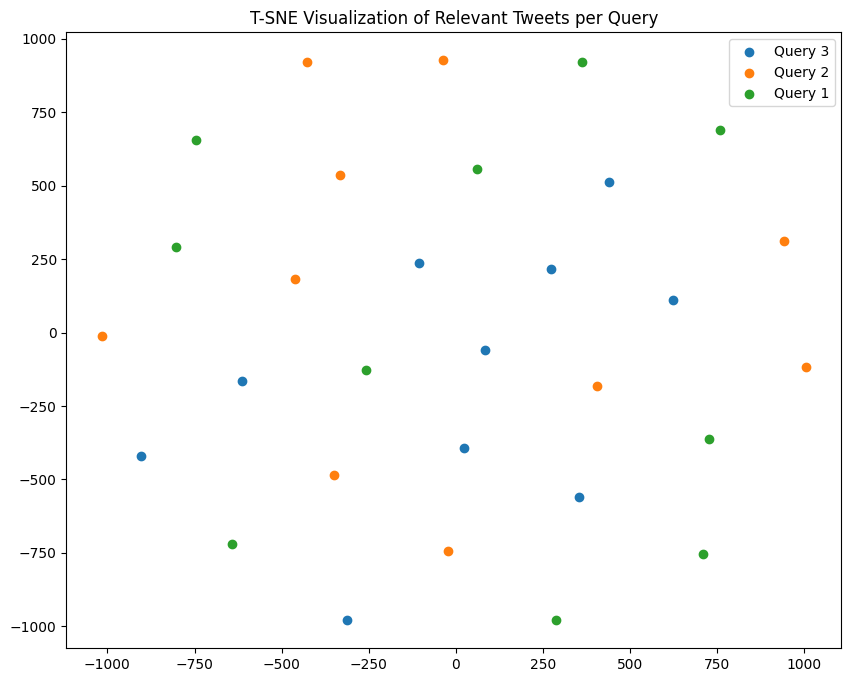

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# Extract relevant tweets for each query
relevant_tweets = search_results[search_results['label'] == 1]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(relevant_tweets['doc'])

# T-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
tsne_result = tsne.fit_transform(tfidf_matrix.toarray())

# Visualization with different colors for each query
plt.figure(figsize=(10, 8))
for query_id in relevant_tweets['query_id'].unique():
    query_mask = relevant_tweets['query_id'] == query_id
    plt.scatter(tsne_result[query_mask, 0], tsne_result[query_mask, 1], label=f'Query {query_id}')

plt.title('T-SNE Visualization of Relevant Tweets per Query')
plt.legend()
plt.show()


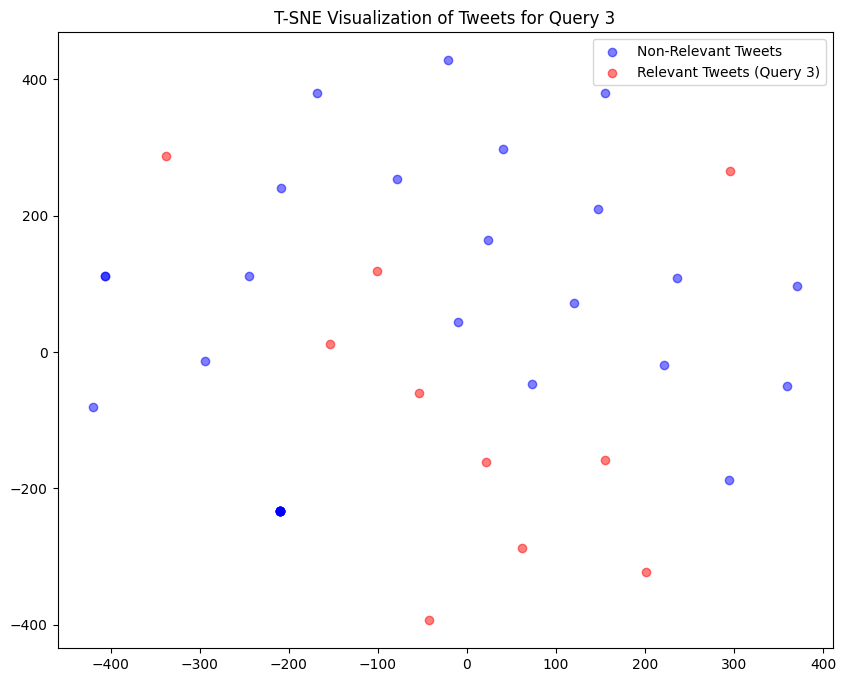

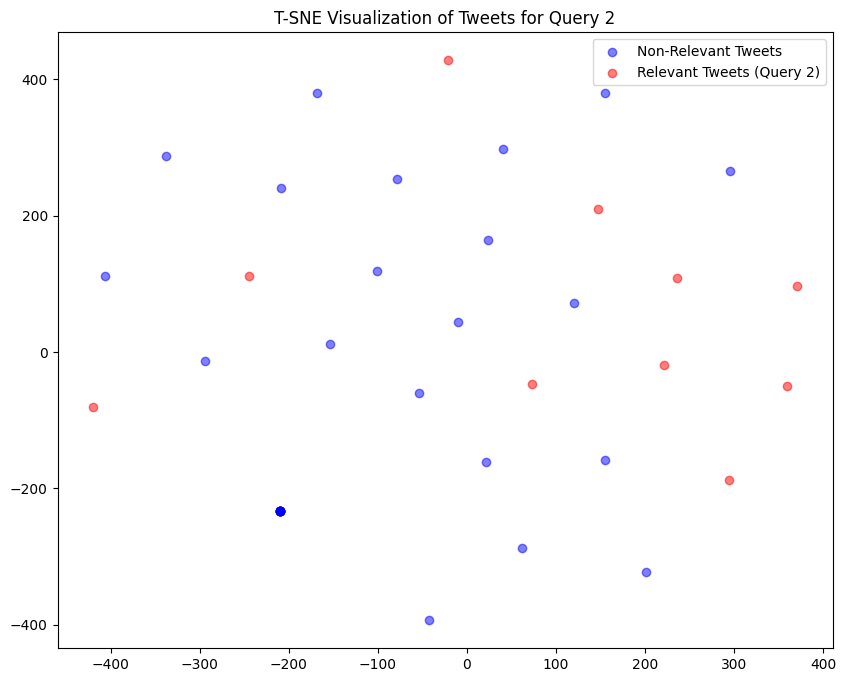

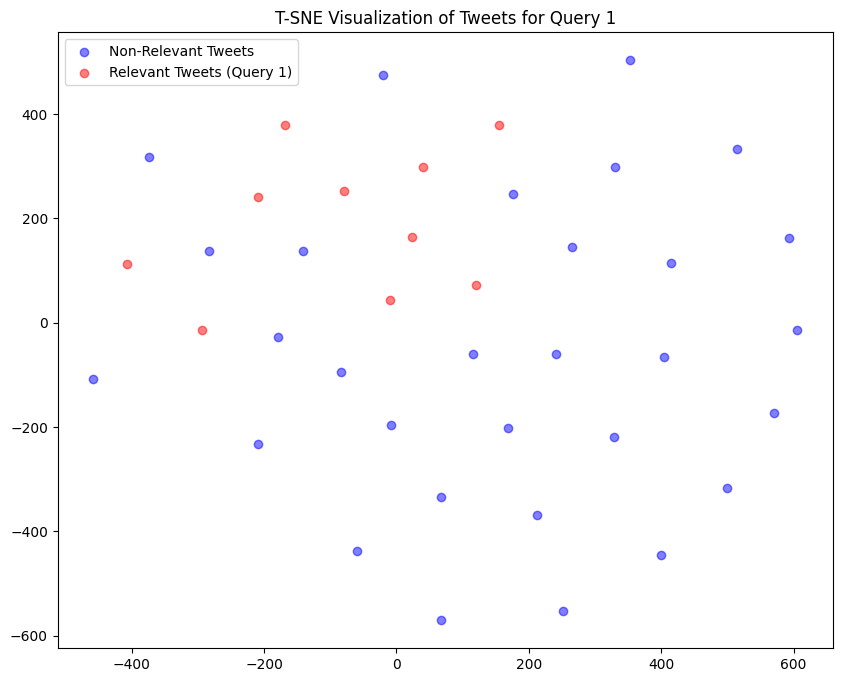

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'search_results' is your dataframe with tweet data

# TF-IDF Vectorization for all tweets
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(search_results['doc'])

# T-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(tfidf_matrix.toarray())

# Define colors for relevant and non-relevant tweets
relevant_color = 'red'
non_relevant_color = 'blue'

# Iterate over each unique query and create a separate plot
for query_id in search_results['query_id'].unique():
    relevant_mask = (search_results['query_id'] == query_id) & (search_results['label'] == 1)
    non_relevant_mask = (search_results['query_id'] == query_id) & (search_results['label'] == 0)
    
    # Create a new plot for each query
    plt.figure(figsize=(10, 8))
    
    # Plot non-relevant tweets in blue
    plt.scatter(tsne_result[non_relevant_mask, 0], tsne_result[non_relevant_mask, 1], color=non_relevant_color, label='Non-Relevant Tweets', alpha=0.5)
    
    # Plot relevant tweets in red
    plt.scatter(tsne_result[relevant_mask, 0], tsne_result[relevant_mask, 1], color=relevant_color, label=f'Relevant Tweets (Query {query_id})', alpha=0.5)

    plt.title(f'T-SNE Visualization of Tweets for Query {query_id}')
    plt.legend()
    plt.show()


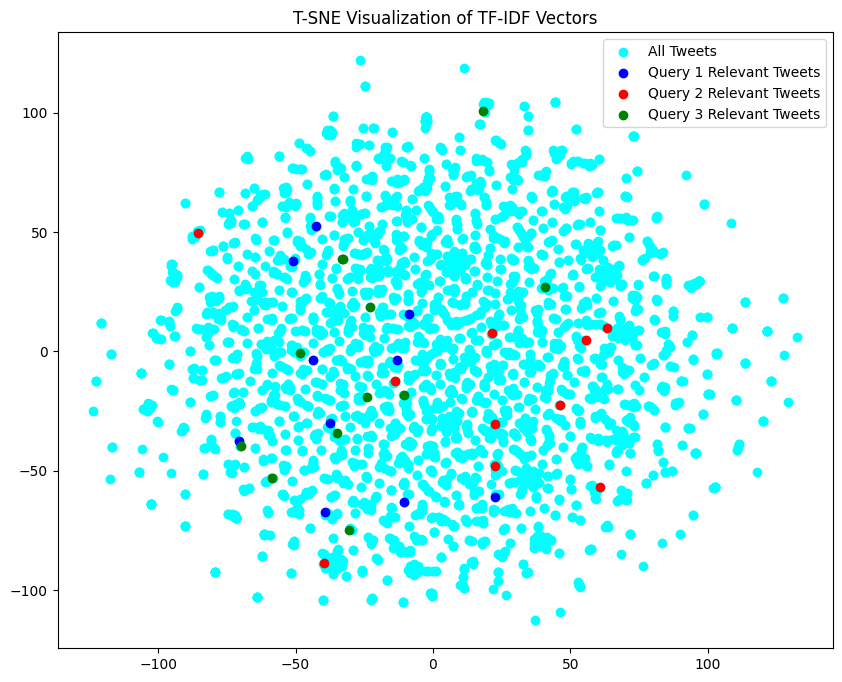

In [37]:
relevant_doc = {}

for query_id in search_results['query_id'].unique():
    relevant_doc[query_id] = []
    for index, row in search_results[search_results['query_id'] == query_id].iterrows():
        if row['label'] == 1:
            relevant_doc[query_id].append(row['doc'])

relevant_tweets = {}
for query_id in search_results['query_id'].unique():
    relevant_tweets[query_id] = []
    for i in relevant_doc[query_id]:
       relevant_tweets[query_id].append([tweet_document_ids_map[i], tweet_information[tweet_document_ids_map[i]]['Processed Tweet']])

# {Q3: [doc_id, processed_tweet][doc_id, processed_tweet]...}

all_tweets = [' '.join(tweet_info['Processed Tweet']) for tweet_info in tweet_information.values()]

# ['hola que']['adeu bla']

query1_tweets = [' '.join(tweet_info[1]) for tweet_info in relevant_tweets[1]]
query2_tweets = [' '.join(tweet_info[1]) for tweet_info in relevant_tweets[2]]
query3_tweets = [' '.join(tweet_info[1]) for tweet_info in relevant_tweets[3]]

all_t = [i for i in all_tweets if i not in query1_tweets]
all_t = [i for i in all_t if i not in query2_tweets]
all_t = [i for i in all_t if i not in query3_tweets]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Initialize TF-IDF vectorizer with a maximum of 5000 features
tfidf_matrix_all = tfidf_vectorizer.fit_transform(all_tweets)  # Apply vectorizer to all tweets to create TF-IDF matrix

# T-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=2)  # Initialize T-SNE with 2 components, random seed for reproducibility, and perplexity 
tsne_result_all = tsne.fit_transform(tfidf_matrix_all.toarray())  # Apply T-SNE to the TF-IDF matrix for all tweets

# Separate T-SNE results for each set of tweets
# Extract T-SNE results for all tweets
tsne_result = tsne_result_all[:len(all_t)]

# Extract T-SNE results for query 1 tweets
tsne_result1 = tsne_result_all[len(all_t):len(all_t) + len(query1_tweets)]

# Extract T-SNE results for query 2 tweets
tsne_result2 = tsne_result_all[len(all_t) + len(query1_tweets):len(all_t) + len(query1_tweets) + len(query2_tweets)]

# Extract T-SNE results for query 3 tweets
tsne_result3 = tsne_result_all[len(all_t) + len(query1_tweets) + len(query2_tweets):]


# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], marker='o', color='cyan', label='All Tweets')
plt.scatter(tsne_result1[:, 0], tsne_result1[:, 1], marker='o', color='blue', label='Query 1 Relevant Tweets')
plt.scatter(tsne_result2[:, 0], tsne_result2[:, 1], marker='o', color='red', label='Query 2 Relevant Tweets')
plt.scatter(tsne_result3[:, 0], tsne_result3[:, 1], marker='o', color='green', label='Query 3 Relevant Tweets')

plt.title('T-SNE Visualization of TF-IDF Vectors')
plt.legend()
plt.show()

QUERY 3


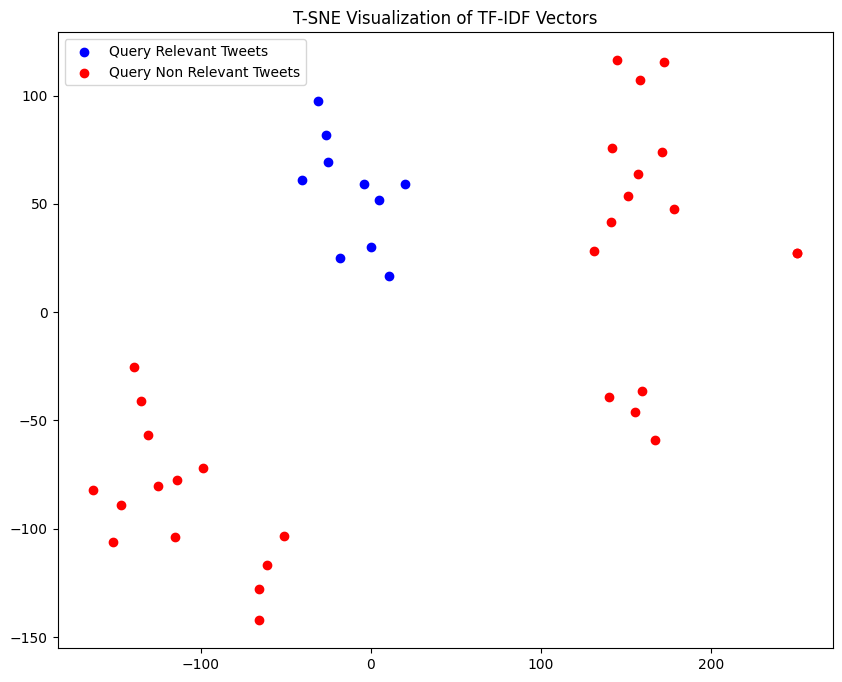

QUERY 2


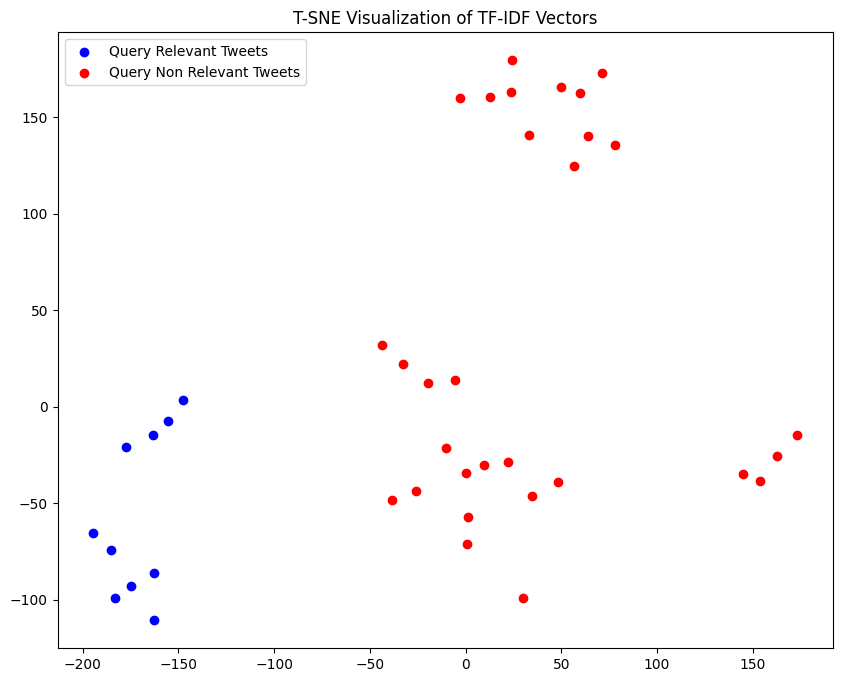

QUERY 1


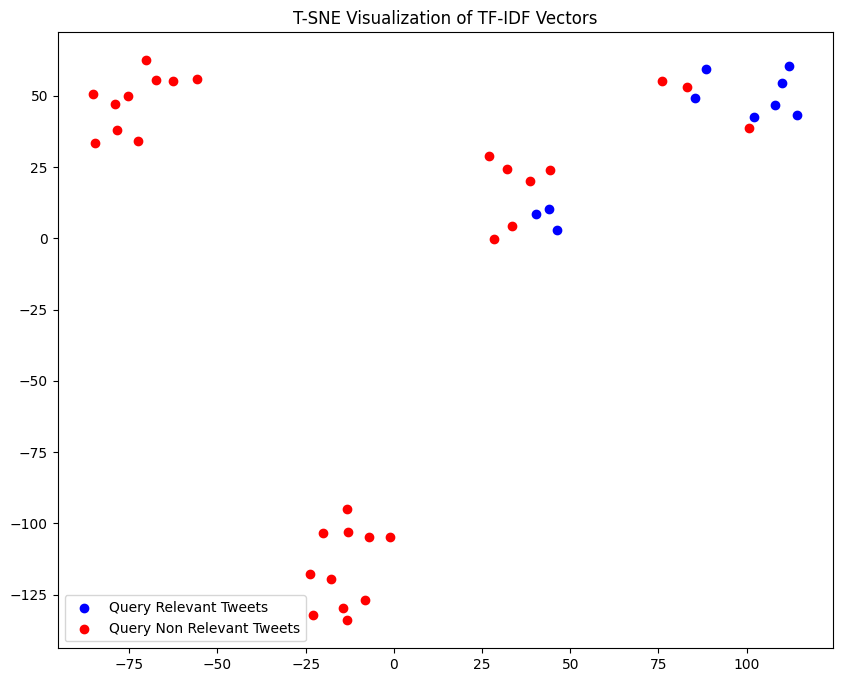

In [35]:
relevant_doc = {}
non_relevant_doc = {}
for query_id in search_results['query_id'].unique():
    relevant_doc[query_id] = []
    non_relevant_doc[query_id] = []
    for index, row in search_results[search_results['query_id'] == query_id].iterrows():
        if row['label'] == 1:
            relevant_doc[query_id].append(row['doc'])
        else:
            non_relevant_doc[query_id].append(row['doc'])


relevant_tweets = {}
non_relevant_tweets = {}
for query_id in search_results['query_id'].unique():
    relevant_tweets[query_id] = []
    non_relevant_tweets[query_id] = []
    for i in relevant_doc[query_id]:
       relevant_tweets[query_id].append([tweet_document_ids_map[i], tweet_information[tweet_document_ids_map[i]]['Processed Tweet']])
    for i in non_relevant_doc[query_id]:
       non_relevant_tweets[query_id].append([tweet_document_ids_map[i], tweet_information[tweet_document_ids_map[i]]['Processed Tweet']])

query1_relevant_tweets = [' '.join(tweet_info[1]) for tweet_info in relevant_tweets[1]]
query1_non_relevant_tweets = [' '.join(tweet_info[1]) for tweet_info in non_relevant_tweets[1]]

query2_relevant_tweets = [' '.join(tweet_info[1]) for tweet_info in relevant_tweets[2]]
query2_non_relevant_tweets = [' '.join(tweet_info[1]) for tweet_info in non_relevant_tweets[2]]

query3_relevant_tweets = [' '.join(tweet_info[1]) for tweet_info in relevant_tweets[3]]
query3_non_relevant_tweets = [' '.join(tweet_info[1]) for tweet_info in non_relevant_tweets[3]]

all_t = [query1_relevant_tweets+query1_non_relevant_tweets, query2_relevant_tweets+query2_non_relevant_tweets, query3_relevant_tweets+query3_non_relevant_tweets]
for query_id in search_results['query_id'].unique():
    # TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Initialize TF-IDF vectorizer with a maximum of 5000 features
    tfidf_matrix_all = tfidf_vectorizer.fit_transform(all_t[query_id-1])  # Apply vectorizer to all tweets to create TF-IDF matrix

    # T-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=2)  # Initialize T-SNE with 2 components, random seed for reproducibility, and perplexity 
    tsne_result_all = tsne.fit_transform(tfidf_matrix_all.toarray())  # Apply T-SNE to the TF-IDF matrix for all tweets

    # Separate T-SNE results for each set of tweets
    # Extract T-SNE results for relevant_tweets 
    tsne_result1 = tsne_result_all[:len(query1_relevant_tweets)]

    # Extract T-SNE results for non_relevant_tweets 
    tsne_result2 = tsne_result_all[len(query1_relevant_tweets):]

    # Visualization
    print('QUERY', query_id)
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_result1[:, 0], tsne_result1[:, 1], marker='o', color='blue', label='Query Relevant Tweets')
    plt.scatter(tsne_result2[:, 0], tsne_result2[:, 1], marker='o', color='red', label='Query Non Relevant Tweets')

    plt.title('T-SNE Visualization of TF-IDF Vectors')
    plt.legend()
    plt.show()

In [36]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Assuming you have a list of preprocessed tweets
# all_tweets = [' '.join(tweet_info['Processed Tweet']) for tweet_info in tweet_information.values()]

# # TF-IDF Vectorization
# tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
# tfidf_matrix = tfidf_vectorizer.fit_transform(all_tweets)

# # T-SNE for dimensionality reduction
# tsne = TSNE(n_components=2, random_state=42, perplexity=2)
# tsne_result = tsne.fit_transform(tfidf_matrix.toarray())

# # Visualization
# plt.figure(figsize=(10, 8))
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], marker='o')
# plt.title('T-SNE Visualization of TF-IDF Vectors')
# plt.show()
